# **Machine Learning 1**

## **Mini-Lab: SVM & LR Classification**

Randy Kim, Kati Schuerger, Will Sherman

The PlayerUnknown’s Battleground (also known as PUBG) Finish Placement Prediction Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." We are continuing our analysis from **Lab One: "Visualization and Data Preprocessing."** However, we will focus on response transformation to evaluate classification accuracy on quartiles of *winPlacePerc*, which we will evaluate in combination with 10-fold cross-validation

*Note*: We are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric will be covered.

#### Library & Data Import Methods ####

In [1]:
# load libraries|
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import statistics

In [2]:
pubg_raw = pd.read_csv("train_V2.csv")

In [3]:
pubg_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### Data Evaluation & Transformation Prior to Modeling ###

In [4]:
# CREATE NEW DF TO INCLUDE OUR UPDATES
# drop the record with missing value
pubg_df = pubg_raw.dropna()
pubg_df.isnull().values.any()

False

We utilized the analysis from **Lab 1** to inform our approach in dropping NA values as opposed to imputing them. For reference, there was only a single NA value.

<AxesSubplot:>

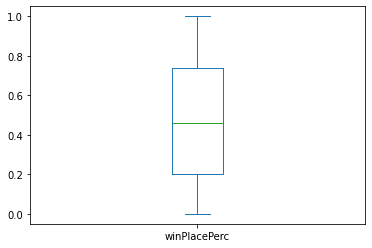

In [5]:
# boxplot of our target variable 
# data looks pretty well-distributed, possibly a little right-skewed
# makes sense = would expect to have fewer records as the quartile increases 
pubg_df.loc[:, 'winPlacePerc'].plot(kind='box')

Our initial approach was to subdivide the players into quartiles and use a classification algorithm to sort players into these quartiles. However, to answer our question of interest, we really only need to predict players in the top (winning) quartile. We changed our methodology to reflect this classification task, and built the models as binary classifiers.

*Given we may pursue incorporating a multiclass prediction model down the line, we have not removed the code to create the other 2 variables that we are not using for this exercise (quartlie and quart_int). Additionally, these were part of our learning process in changing course to build binary classification models.*

In [6]:
# CREATE NEW COLUMN FOR QUARTILES = WE WILL REMOVE AND PREDICT 

# add new quartile vector to pubg_df
# start with "best guess" quartiles 

## quartile variable = object datatype 
pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.25, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.5, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.75, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.75, 'q4',
                                                  'other'))))
## quart_int variable = numeric representation of the quartile that the record belongs to
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.25, '1', 
                       np.where(pubg_df.winPlacePerc < 0.50, '2',
                                np.where(pubg_df.winPlacePerc < 0.75, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.75, '4',
                                                  'other'))))
## quart_binary = binary variable where 1 = record is in the top quartile 
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.75, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.75, '1',
                                                  'other'))
pubg_df.head()

C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1072078856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.25, 'q1',
C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1072078856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.25, '1',
C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1072078856.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.00,0,0,244.80,1,1466,0.4444,q2,2,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,11.04,0,0,1434.00,5,0,0.6400,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.00,0,0,161.80,2,0,0.7755,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.00,0,0,202.70,3,0,0.1667,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.00,0,0,49.75,2,0,0.1875,q1,1,0


In [7]:
# check the spread of our quartiles
quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 29.70%
Percentage of players in Quartile 2: 23.49%
Percentage of players in Quartile 3: 22.18%
Percentage of players in Quartile 4: 24.64%
Miscategorized quartile values:   0


Our data is fairly equally distributed among the 4 quartiles using our "straight cut" initial approach; we think it can be even better. Next, we will update our dataset with equal representation for all 4 quartiles. 

In [8]:
# GATHER INFO TO EQUAL OUT OUR QARTILES 
# pull out the winPlacePerc column
winPlace = pubg_df.loc[:,'winPlacePerc']

# get quartile thresholds for equal allocation |
print('Quartile 1 threshold: {:.2f}'.format(winPlace.quantile(0.25)))
print('Quartile 2 threshold: {:.2f}'.format(winPlace.quantile(0.5)))
print('Quartile 3 threshold: {:.2f}'.format(winPlace.quantile(0.75)))

Quartile 1 threshold: 0.20
Quartile 2 threshold: 0.46
Quartile 3 threshold: 0.74


This tells us that the thresholds between quartiles in our data are a little different from the "basic" quartiles split (0.25, 0.5, 0.75).

We will adjust our thresholds in the 'quartile' column, to reflect the revised thresholds (derived from the actual data).

In [9]:
# overwrite quantile vector with updated thresholds 
# (to create equal distribution among the quantiles)
pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.46, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.74, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, 'q4',
                                                  'other'))))
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1', 
                       np.where(pubg_df.winPlacePerc < 0.46, '2',
                                np.where(pubg_df.winPlacePerc < 0.74, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '4',
                                                  'other'))))
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.74, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '1',
                                                  'other'))
pubg_df.head()

C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1999743836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1',
C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1999743836.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1',
C:\Users\RANDYK~1\AppData\Local\Temp/ipykernel_14340/1999743836.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.00,0,0,244.80,1,1466,0.4444,q2,2,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,11.04,0,0,1434.00,5,0,0.6400,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.00,0,0,161.80,2,0,0.7755,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.00,0,0,202.70,3,0,0.1667,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.00,0,0,49.75,2,0,0.1875,q1,1,0


In [10]:
# check the spread of our quartiles
# make sure they are more equal

quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 24.90%
Percentage of players in Quartile 2: 25.19%
Percentage of players in Quartile 3: 24.53%
Percentage of players in Quartile 4: 25.38%
Miscategorized quartile values:   0


Data is now more equally distributed across the 4 quartiles. 

In [11]:
# REMOVE UNUSEFUL 'OBJECT' (DATATYPE) VARIABLES 
del pubg_df['Id']
del pubg_df['groupId']
del pubg_df['matchId']
del pubg_df['matchType']

The *Id*, *groupId*, and *matchId* features are important for distinguishing distinct players, groups, and matches as part of the original kaggle competition. However, these are not good predictors for our binary classification problem—each triplet will be unique. Therefore, these three are dropped as non-essential.

The *matchType* variable was previously identified as having low correlation and predictive power with respect to the original (continuous) response variable, *winPlacePerc*. As such, we opted to remove it from our predictors.

*Note*: Analysis on *matchType* was provided in **Lab 1** as part of the **EXPLORE ATTRIBUTES & CLASS** section.

In [12]:
# FEATURE COLUMN NAMES

#  get column names to use in our logistic regression model 
cols_df = pubg_df.columns.values.tolist()
cols_df.remove('winPlacePerc') # remove target variable 1 (continuous)
cols_df.remove('quartile') # remove target variable 2 (categorical)
cols_df.remove('quart_int') # remove target variable 2 (numeric representation)
cols_df.remove('quart_binary')
print(cols_df)

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']


Below we re-evaluate the features we have transformed and selected. Above, the **Feature Column Names** code block lists the predictors we will utilize to create the logistic regression model and support vector machine model for the classification task.

In [13]:
pubg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  numGroups        int64  
 14  rankPoints       int64  
 15  revives          int64  
 16  rideDistance     float64
 17  roadKills        int64  
 18  swimDistance     float64
 19  teamKills        int64  
 20  vehicleDestroys  int64  
 21  walkDistance     float64
 22  weaponsAcquired  int64  
 23  winPoints        int64  
 24  winPlacePerc     float64
 25  quartile         object 
 26  quart_int        object 
 27  quart_binary

## **CREATE MODELS** ##

Our initial approach (below) was to use unscaled data and fit a model we have more familiarity with: logistic regression.

This model will be referred to as **simple logit** when discussing advantages and disadvantages.

In [14]:
# SIMPLE LOGIT MODEL 
## Create Logistic Regression Model & Score Model using train, test, split

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

feature_cols = cols_df
X = pubg_df.loc[:, feature_cols]
y = pubg_df.loc[:, 'quart_binary']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.2, random_state=17)

logit_simple = LogisticRegression()
logit_simple.fit(X_train, y_train)

print('Logistic Regression Simple Score: {:.2f}%'.format(logit_simple.score(X_test, y_test)*100))

d:\project\machine learning\machinelearning\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Simple Score: 89.81%


Here we created a pipeline that scales and fit 3 different classifications, Logistic Regression, Decision Tree, and Random Forest, to compare their accuracies. Because of the large dataset, overfitting issue, high variance, and noise, Random Forest performed better than other classifications. Although the training time was slower than others, Random Forest improves accuracy by using its main advantages.

-------------------------------------------------------------------------------

**Logistic Regression Accuracy**: 0.905

**Decision Tree Accuracy**: 0.894

**RandomForest Accuracy**: 0.926


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([('scalar1', StandardScaler()),
                        ('lr_classifier', LogisticRegression(random_state = 0))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', DecisionTreeClassifier())])

pipeline_randomforest = Pipeline([('scalar3', StandardScaler()),
                                  ('rf_classifier', RandomForestClassifier())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]
pipelines

[Pipeline(steps=[('scalar1', StandardScaler()),
                 ('lr_classifier', LogisticRegression(random_state=0))]),
 Pipeline(steps=[('scalar2', StandardScaler()),
                 ('dt_classifier', DecisionTreeClassifier())]),
 Pipeline(steps=[('scalar3', StandardScaler()),
                 ('rf_classifier', RandomForestClassifier())])]

In [16]:
best_accuracy = 0.0
best_classifier = 0
best_pipline = ""

pipe_dic = {0: "Logistic Regression", 1: "Decision Tree", 2: "RandomForest"}

In [17]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [18]:
import time

for i,model in enumerate(pipelines):
    start_time = time.time()
    accuracy = model.score(X_test, y_test)
    print("{} Test Accuracy: {}".format(pipe_dic[i],accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pipeline = model
        best_classifier = i
    print("--- %s seconds ---" % (time.time() - start_time))
print("Classifier with best accuracy: {} with {}.".format(pipe_dic[best_classifier], best_accuracy))

Logistic Regression Test Accuracy: 0.9047147886255008
--- 9.554466009140015 seconds ---
Decision Tree Test Accuracy: 0.8941143004273702
--- 9.136658906936646 seconds ---
RandomForest Test Accuracy: 0.9260816084677977
--- 101.17079305648804 seconds ---
Classifier with best accuracy: RandomForest with 0.9260816084677977.


#### **Regression Model to Predict Binary Classification Variable**


In [19]:
# TRAIN TEST SPLIT 
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'quart_binary' in pubg_df:
    y = pubg_df['quart_binary'].values # get the labels we want


    del pubg_df['quart_binary'] # get rid of the class label
    del pubg_df['quart_int']
    del pubg_df['quartile']
    del pubg_df['winPlacePerc'] # get rid of the continuous variable we built the quartile label from 

    X = pubg_df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits (80/20 split)
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, random_state = 7,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=7, test_size=0.2, train_size=None)


In [20]:
%%time
from pandas.core.common import random_state
# ADD CODE TO CREATE TEST/TRAIN OBJECTS 
### BORROWED FROM JAKE DREW'S GITHUB

# run logistic regression and vary some parameters

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', random_state = 7) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

acc = []
weights = []
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions
    weights.append(lr_clf.coef_[0])

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc.append(mt.accuracy_score(y_test,y_hat))
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc[iter_num] )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.9053050788571532
confusion matrix
 [[624824  38518]
 [ 45703 180348]]
====Iteration 1  ====
accuracy 0.9043954697192355
confusion matrix
 [[624996  38926]
 [ 46104 179367]]
====Iteration 2  ====
accuracy 0.9048429659329453
confusion matrix
 [[625037  38900]
 [ 45732 179724]]
====Iteration 3  ====
accuracy 0.9045663727958282
confusion matrix
 [[625002  38662]
 [ 46216 179513]]
====Iteration 4  ====
accuracy 0.9045517560853301
confusion matrix
 [[624214  39232]
 [ 45659 180288]]
====Iteration 5  ====
accuracy 0.904765384931071
confusion matrix
 [[623993  39132]
 [ 45569 180699]]
====Iteration 6  ====
accuracy 0.9048553339187513
confusion matrix
 [[624564  38960]
 [ 45661 180208]]
====Iteration 7  ====
accuracy 0.9047102911761168
confusion matrix
 [[624776  38746]
 [ 46004 179867]]
====Iteration 8  ====
accuracy 0.9046675654069686
confusion matrix
 [[624375  38876]
 [ 45912 180230]]
====Iteration 9  ====
accuracy 0.9052533581892369
confusion matrix
 [[6250

In [21]:
statistics.mean(acc)
weights = np.array(weights)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

The above code gives us predictive models with around 90% accuracy consistently. On the flip side, it takes quite a bit of time to run (around 22 min.).

Our accuracy could potentially be misleading, possibly overfitting the data. 

#### **Logistic Regression using Stochastic Gradient Descent**

In [22]:
# FIRST, WE CREATE OUR TRAIN/TEST SPLIT ON THE DATA
# TRAIN TEST SPLIT 
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'quart_binary' in pubg_df:
    y = pubg_df['quart_binary'].values # get the labels we want


    del pubg_df['quart_binary'] # get rid of the class label
    del pubg_df['quart_int']
    del pubg_df['quartile']
    del pubg_df['winPlacePerc'] # get rid of the continuous variable we built the quartile label from 

    X = pubg_df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
# of the object and set it up. This object will be able to split our data into 
# training and testing splits (80/20 split)
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, random_state = 7,
                         test_size  = 0.2)
                         
print(cv_object)

## code adapted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


ShuffleSplit(n_splits=10, random_state=7, test_size=0.2, train_size=None)


Whereas linear regression minimizes squared error, logistic regression minimizes log-loss (also known as cross-entropy). [This article](http://rasbt.github.io/mlxtend/user_guide/classifier/LogisticRegression/) can be referenced for a detailed explanation.

In [23]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent

from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

""
regularize_const = 0.1
iterations = 5
acc = []

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc.append(mt.accuracy_score(y[test_idx],yhat))

print('Logistic Regression using SGD:', statistics.mean(acc))

## code adapted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


Logistic Regression using SGD: 0.8815756364171969
Wall time: 3min 12s


Utilizing *SGDClassifier()* allowed us to train a model in a much shorter timeframe than the previous regression models.

In [24]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent

regularize_const = 0.1
iterations = 5
acc = []

svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc.append(mt.accuracy_score(y[test_idx],yhat))

print('Support Vector Machine using SGD:', statistics.mean(acc))

## code adapted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


Support Vector Machine using SGD: 0.8944622905734585
Wall time: 2min 57s


We trained the *SGDClassifier()* with the hinge loss, which is equivalent to a linear SVM (reference: https://scikit-learn.org/stable/modules/sgd.html#sgd).

## **MODEL ADVANTAGES**

The logistic model using stochastic gradient descent (SGD) runs much faster than the previous models. The 10-fold cross-validation of the original regression model (*i.e.*, **lr_clf**) took over 20 minutes. The SGD approach takes around 3 minutes to run a 10-fold cross-validation.

The trade off is that we see a slightly lower average accuracy score (we pay for our improved computing speed with about 1 to 2% accuracy = it drops from around 90% to around 88%).

But, 88% accuracy is still pretty solid. Additionally, the variance of the scores doesn't seem to suffer drastically. As for next steps, we could explore methods to reduce the  dimensionality of our data, to see if we can bring our accuracy score up without a substantal increase in processing time.

Both *SGDClassifier*s show marked improvement over the DecisionTree and RandomForest approaches, both in terms of accuracy scores and in terms of time-to-completion.

Lastly, between the logistic regression using stochastic gradient descent and the support vector machine, it appears that the SVM model has a slight advantage both in terms of run-time and accuracy.

In [25]:
### Attempt to optimize logistic model
'''
from sklearn.model_selection import GridSearchCV
params = {
    'alpha' : [1e-3, 1e-2, 1e-1],
    'penalty' : ['l1', 'l2', 'elasticnet']
}

clf = SGDClassifier(max_iter=4000)
grid = GridSearchCV(clf, param_grid=params, cv=10)

grid.fit(X_train, y_train)

print(grid.best_params_)
'''

"\nfrom sklearn.model_selection import GridSearchCV\nparams = {\n    'alpha' : [1e-3, 1e-2, 1e-1],\n    'penalty' : ['l1', 'l2', 'elasticnet']\n}\n\nclf = SGDClassifier(max_iter=4000)\ngrid = GridSearchCV(clf, param_grid=params, cv=10)\n\ngrid.fit(X_train, y_train)\n\nprint(grid.best_params_)\n"

There were two issues with attempting to optimize model hyperparameters. One was that the run-time for evaluation was very large due to having a large *max_iter*. The other issue was that, despite having a large *max_iter*, the model was encountering a convergence warning (*i.e.*, `ConvergenceWarning: Maximum number of iteration reached before convergence`.)

*Note*: the *params* in the above model have been scaled down multiple times in terms of number of iterations.

## **INTERPRETING FEATURE IMPORTANCE**

In [26]:
# INTERPRETTING WEIGHTS

# iterate over the coefficients
weights = log_sgd.coef_.T
variable_names = cols_df
for coef, name in zip(weights, variable_names):
    print(name, 'has weight of', coef[0])

assists has weight of 0.12016952769280179
boosts has weight of 0.3709022066804795
damageDealt has weight of 0.06960790641719633
DBNOs has weight of -0.05499371611409899
headshotKills has weight of 0.016049636493763782
heals has weight of 0.10278468912310824
killPlace has weight of -0.36767976197598745
killPoints has weight of 0.004335865804260248
kills has weight of 0.03821002331909638
killStreaks has weight of -0.02751070914065466
longestKill has weight of 0.11993006658601438
matchDuration has weight of -0.1702190904040651
maxPlace has weight of 0.05996594015865812
numGroups has weight of 0.0597018207290792
rankPoints has weight of 0.009721573036806637
revives has weight of 0.05239085505945618
rideDistance has weight of 0.14525836418101407
roadKills has weight of 0.0036621175502193687
swimDistance has weight of 0.09578324247835072
teamKills has weight of -0.031214418396063037
vehicleDestroys has weight of 0.0031756056761965035
walkDistance has weight of 0.715917419848286
weaponsAcquir

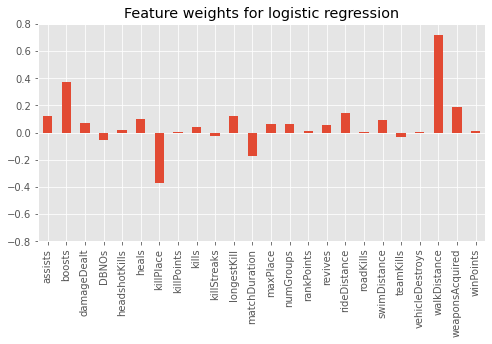

In [27]:
%matplotlib inline
plt.style.use('ggplot')

weights_graph = pd.Series(weights.flatten(), index=variable_names)
plt.figure(figsize=(8, 4))
plt.ylim(ymin=-.8,ymax=.8)
weights_graph.plot(kind='bar')
plt.title('Feature weights for logistic regression')
plt.show()

Looking at these coefficients is interesting, they suggest that *walkDistance* and *boosts* have the largest positive influence on target prediction. The *killPlace* variable has a noticeable negative association with prediction of our binary "top 25%" classification QOI.

*killPlace* and *boosts* were part of our initial assessment as predictors of interest from **Lab 1**. Our knowledge of PUBG matches and the fact that there is no "*survivalTime*" variable leads us to assume that *walkDistance* may be analogous to in-game survival.

All other vectors have weights less than 0.2.

## **INTERPRETING SUPPORT VECTORS**

*Below code adapted from: https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html*

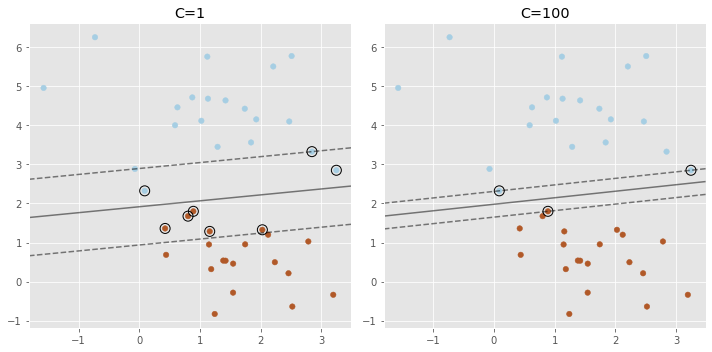

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
    )
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(
        xx,
        yy,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

The above code gives a representation of the support vectors for our classification QOI. The support vectors  are the instances that lie *on* the hyperplane boundary separating our classifications. These represent maximized margins between our binary classes; but because we are running our model against multi-variate data, the support vectors exist on hyperplanes separating our data as optimally as possible.

As we increase the regularization parameter (*i.e.* C), we decrease the strength of regularization: "The strength of the regularization is inversely proportional to C." ([reference](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)). In other words, a larger C overfits on our training data—as seen above.

In [29]:
# code adapted from: https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(X, y) 
print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))

w =  [[ 0.50616919 -3.03777007]]
b =  [6.01254062]
Indices of support vectors =  [ 3 35  1]
Support vectors =  [[3.2460247  2.84942165]
 [0.08848433 2.32299086]
 [0.89011768 1.79849015]]
Number of support vectors for each class =  [2 1]
Coefficients of the support vector in the decision function =  [[1.04405632 3.6997822  4.74383851]]
